# Am I feeding my network crap

Given that my research on the image content of optical flow images shows such huge variety is my image generation doing  anything useful to it??? Perhaps experiment with a very small network for say only 10 classes?? 

First lets look at the output for something relatively easy like cricket 

In [1]:
import os
import sys


up1 = os.path.abspath('../../utils/') 
up2 = os.path.abspath('../../models/') 
sys.path.insert(0, up1)
sys.path.insert(0, up2)

In [2]:
from optical_flow_data_gen import DataGenerator
from ucf101_data_utils import get_test_data_opt_flow, get_train_data_opt_flow
from motion_network import getKerasCifarMotionModel2, getKerasCifarMotionModelOnly
from keras.optimizers import SGD
from matplotlib import pyplot as plt
from keras.optimizers import SGD
import cv2 
import numpy as np


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [15]:

training_options = { 'rescale' : 1./255, \
                            'shear_range' : 0.2, \
                            'zoom_range' : 0.2, \
                         'samplewise_center' : True, \
                         'samplewise_std_normalization' : True \
    }




params_train = { 'data_dir' : "/data/tvl1_flow",
          'dim': (224,224),
          'batch_size': 256,
          'n_frames': 1,
          'n_frequency': 1,
          'shuffle': False, 
           'validation' : False,
               'training_opts' : training_options }


In [16]:
id_labels_train = get_train_data_opt_flow('../../data/ucf101_splits/trainlist01.txt')

training_generator = DataGenerator(*id_labels_train, **params_train)



In [17]:
_X = None
_y = None

for (X, y) in training_generator:
    _X = X
    _y = y
    break

In [6]:
_X.shape

(256, 224, 224, 2)

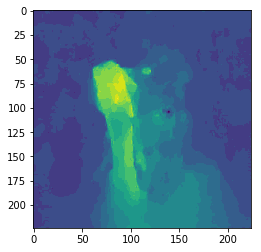

In [7]:
plt.imshow(_X[0,:,:,0])

In [35]:
_X[0,5,5,0]

-0.049472440473817075

In [36]:

training_options = { 'rescale' : 1./255
    }




params_train = { 'data_dir' : "/data/tvl1_flow",
          'dim': (224,224),
          'batch_size': 256,
          'n_frames': 1,
          'n_frequency': 1,
          'shuffle': False, 
           'validation' : False,
               'training_opts' : training_options }

id_labels_train = get_train_data_opt_flow('../../data/ucf101_splits/trainlist01.txt')

training_generator = DataGenerator(*id_labels_train, **params_train)


In [23]:
_X = None
_y = None

for (X, y) in training_generator:
    _X = X
    _y = y
    break

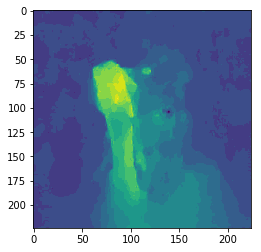

In [38]:
plt.imshow(_X[0,:,:,0])

In [39]:
_X[0,5,5,0]

0.4980392156862745

# Is it the data or my classifier

I am starting to wonder what it is about my optical flow data that might be causing so much easier. Regardless about the unconverged flow images I feel the author of the data still managed with it. So there's essentially two things I can either get a large amount of improvement simply on how I train my classifier (slower?), or my data set is not quite right. I've already seen that I wasn't even doing any random transforms on my opt flow images courtesy my badly written opt flow data generator. 
Any how what I am aiming to do is use a stinkingly cheap data model to explore what might be wrong. 

In [3]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.initializers import Ones
from keras import optimizers

def getModel(lr=1e-2):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(224, 224, 2)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10))
    model.add(Activation('sigmoid'))

    optimizers.SGD(lr=lr)
    model.compile(loss='categorical_crossentropy',
                  optimizer='sgd',
                  metrics=['accuracy'])
    return model

In [4]:
model_fast_lr = getModel(lr=1e-2)

In [5]:
from optical_flow_data_gen import DataGenerator
from ucf101_data_utils import get_test_data_opt_flow, get_train_data_opt_flow

training_options = { 'rescale' : 1./255, 
                            'shear_range' : 0.2, 
                            'zoom_range' : 0.2, 
                            'horizontal_flip' : True,
                             'rotation_range':20,
                             'width_shift_range':0.2,
                             'height_shift_range':0.2}

validation_options = { 'rescale' : 1./255 }




params_train = { 'data_dir' : "/data/tvl1_flow",
          'dim': (224,224),
          'batch_size': 16,
          'n_frames': 1,
          'n_frequency': 1,
          'shuffle': True, 
                'n_classes' : 10,
           'validation' : False}

params_valid = { 'data_dir' : "/data/tvl1_flow",
          'dim': (224,224),
          'batch_size': 16,
          'n_frames': 1,
          'n_frequency': 1,
          'shuffle': True, 
                'n_classes' : 10,
           'validation' : True}

id_labels_train = get_train_data_opt_flow('../../data/ucf101_splits/trainlist01_small.txt')
labels = id_labels_train[1]
id_test = get_test_data_opt_flow('../../data/ucf101_splits/testlist01_small.txt', \
                       '../../data/ucf101_splits/classInd_small.txt')

training_generator = DataGenerator(*id_labels_train, **params_train)


validation_generator = DataGenerator(id_test[0], id_test[1], **params_valid)

In [6]:
mod1 = model_fast_lr.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=True,
                    workers=2, epochs=15,
                    verbose=1)

Epoch 1/15
61/61 [==============================] - 101s 2s/step - loss: 2.2726 - acc: 0.1014 - val_loss: 2.2543 - val_acc: 0.1667
Epoch 2/15
61/61 [==============================] - 7s 113ms/step - loss: 2.2296 - acc: 0.1916 - val_loss: 2.2324 - val_acc: 0.2526
Epoch 3/15
61/61 [==============================] - 8s 128ms/step - loss: 2.1817 - acc: 0.2336 - val_loss: 2.1831 - val_acc: 0.2500
Epoch 4/15
61/61 [==============================] - 7s 117ms/step - loss: 2.1584 - acc: 0.2428 - val_loss: 2.1564 - val_acc: 0.2552
Epoch 5/15
61/61 [==============================] - 6s 100ms/step - loss: 2.1087 - acc: 0.2336 - val_loss: 2.1668 - val_acc: 0.2839
Epoch 6/15
61/61 [==============================] - 7s 109ms/step - loss: 2.0815 - acc: 0.2439 - val_loss: 2.0929 - val_acc: 0.2786
Epoch 7/15
61/61 [==============================] - 8s 134ms/step - loss: 2.1100 - acc: 0.2500 - val_loss: 2.0715 - val_acc: 0.2917
Epoch 8/15
61/61 [==============================] - 6s 98ms/step - loss: 2.02

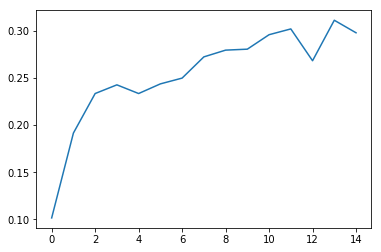

In [7]:
plt.plot(mod1.history['acc'])

In [8]:
mod2 = model_fast_lr.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=True,
                    workers=2, epochs=15,
                    verbose=1)

Epoch 1/15
61/61 [==============================] - 7s 122ms/step - loss: 1.9850 - acc: 0.3023 - val_loss: 2.0750 - val_acc: 0.3177
Epoch 2/15
61/61 [==============================] - 6s 93ms/step - loss: 1.9833 - acc: 0.3207 - val_loss: 1.9595 - val_acc: 0.3620
Epoch 3/15
61/61 [==============================] - 6s 99ms/step - loss: 1.9938 - acc: 0.3115 - val_loss: 1.9471 - val_acc: 0.3646
Epoch 4/15
61/61 [==============================] - 6s 104ms/step - loss: 1.8720 - acc: 0.3371 - val_loss: 1.9647 - val_acc: 0.3490
Epoch 5/15
61/61 [==============================] - 7s 113ms/step - loss: 1.9206 - acc: 0.3084 - val_loss: 1.9263 - val_acc: 0.3672
Epoch 6/15
61/61 [==============================] - 6s 97ms/step - loss: 1.8648 - acc: 0.3484 - val_loss: 1.9005 - val_acc: 0.3333
Epoch 7/15
61/61 [==============================] - 7s 110ms/step - loss: 1.8812 - acc: 0.3381 - val_loss: 1.9387 - val_acc: 0.3359
Epoch 8/15
61/61 [==============================] - 6s 99ms/step - loss: 1.9235

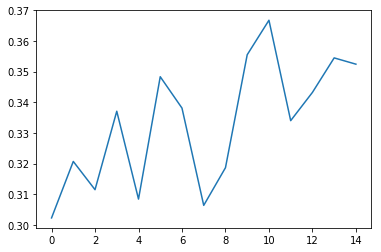

In [9]:
plt.plot(mod2.history['acc'])

In [10]:
model_slow_lr = getModel(lr=1e-4)

In [11]:
mod1 = model_slow_lr.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=True,
                    workers=2, epochs=30,
                    verbose=1)

Epoch 1/30
61/61 [==============================] - 7s 112ms/step - loss: 2.2669 - acc: 0.1352 - val_loss: 2.2375 - val_acc: 0.2057
Epoch 2/30
61/61 [==============================] - 6s 106ms/step - loss: 2.2418 - acc: 0.1516 - val_loss: 2.2154 - val_acc: 0.2786
Epoch 3/30
61/61 [==============================] - 7s 113ms/step - loss: 2.1845 - acc: 0.2152 - val_loss: 2.2004 - val_acc: 0.2240
Epoch 4/30
61/61 [==============================] - 7s 108ms/step - loss: 2.1905 - acc: 0.2408 - val_loss: 2.1299 - val_acc: 0.2917
Epoch 5/30
61/61 [==============================] - 6s 99ms/step - loss: 2.1388 - acc: 0.2326 - val_loss: 2.2008 - val_acc: 0.2812
Epoch 6/30
61/61 [==============================] - 6s 96ms/step - loss: 2.1301 - acc: 0.2459 - val_loss: 2.1473 - val_acc: 0.2526
Epoch 7/30
61/61 [==============================] - 5s 83ms/step - loss: 2.1000 - acc: 0.2305 - val_loss: 2.0987 - val_acc: 0.2448
Epoch 8/30
61/61 [==============================] - 6s 94ms/step - loss: 2.1008

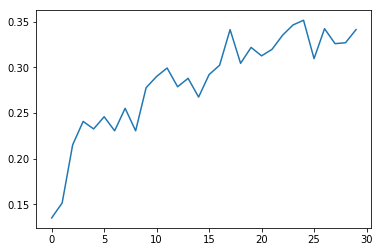

In [12]:
plt.plot(mod1.history['acc'])

In [13]:
mod2 = model_slow_lr.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=True,
                    workers=2, epochs=30,
                    verbose=1)

Epoch 1/30
61/61 [==============================] - 6s 104ms/step - loss: 1.8978 - acc: 0.3412 - val_loss: 1.8948 - val_acc: 0.3151
Epoch 2/30
61/61 [==============================] - 5s 88ms/step - loss: 1.8544 - acc: 0.3525 - val_loss: 1.9496 - val_acc: 0.3464
Epoch 3/30
61/61 [==============================] - 5s 90ms/step - loss: 1.9235 - acc: 0.3289 - val_loss: 1.9195 - val_acc: 0.3802
Epoch 4/30
61/61 [==============================] - 6s 92ms/step - loss: 1.8677 - acc: 0.3719 - val_loss: 1.9481 - val_acc: 0.3620
Epoch 5/30
61/61 [==============================] - 6s 104ms/step - loss: 1.9005 - acc: 0.3463 - val_loss: 1.9675 - val_acc: 0.2969
Epoch 6/30
61/61 [==============================] - 7s 110ms/step - loss: 1.8262 - acc: 0.3443 - val_loss: 2.0103 - val_acc: 0.3073
Epoch 7/30
61/61 [==============================] - 5s 87ms/step - loss: 1.8413 - acc: 0.3402 - val_loss: 2.0154 - val_acc: 0.3255
Epoch 8/30
61/61 [==============================] - 5s 87ms/step - loss: 1.8591 

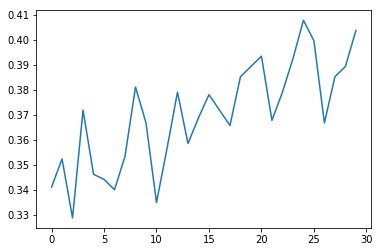

In [14]:
plt.plot(mod2.history['acc'])

In [15]:
model_slow_lr.save_weights(filepath='../../data/weights/model_slow_lr.hdf5')